In [ ]:
import requests
import zipfile
import os

output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)  

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"

zip_path = os.path.join(output_dir, "jena_climate_2009_2016.csv.zip")

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(zip_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"File saved in: {zip_path}")
else:
    print(f"code status: {response.status_code}")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(output_dir)  
    print(f"Files extracted in: {output_dir}")

csv_path = os.path.join(output_dir, "jena_climate_2009_2016.csv")
if os.path.exists(csv_path):
    print(f"CSV file found in: {csv_path}")
else:
    print("Error")

Descarga completada. Archivo guardado en: ../data\jena_climate_2009_2016.csv.zip
Descompresión completada. Archivos extraídos en: ../data
Archivo CSV encontrado: ../data\jena_climate_2009_2016.csv


In [21]:
with open(csv_path) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [30]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

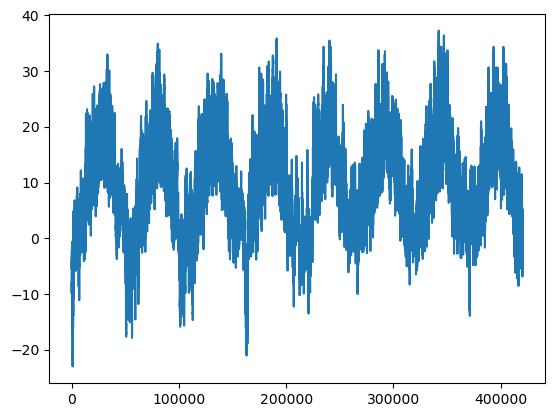

In [36]:
from matplotlib import pyplot as plt 
plt.plot(range(len(temperature)), temperature)
plt.show()

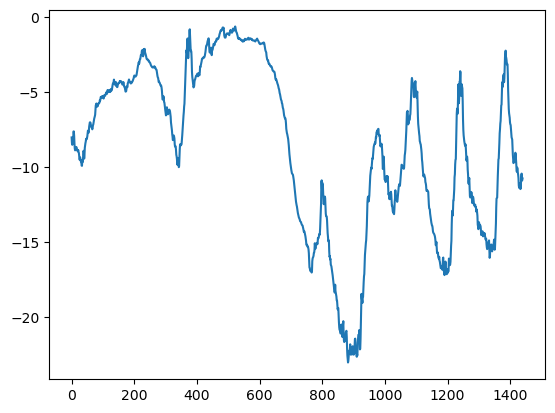

In [41]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [42]:
num_train_samples = int(0.5*len(raw_data))
num_val_samples = int(0.25*len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print('num_train_samples: ', num_train_samples)
print('num_val_samples: ', num_val_samples)
print('num_test_samples: ', num_test_samples)

num_train_samples:  210225
num_val_samples:  105112
num_test_samples:  105114


In [43]:
#Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [44]:
from tensorflow import keras
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length+24-1)
batch_size =256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [47]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [48]:
#comon sense baseline MAE
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [57]:
raw_data.shape[-1]

14

In [50]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras',
                                    save_best_only = True)
]
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
history = model.fit(train_dataset,
                    epochs = 10, 
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model('jena_dense.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 12.3652 - mae: 2.7163 - val_loss: 10.3683 - val_mae: 2.5513
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.7749 - mae: 2.3313 - val_loss: 10.7402 - val_mae: 2.5825
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 8.0302 - mae: 2.2330 - val_loss: 11.2422 - val_mae: 2.6423
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.5989 - mae: 2.1727 - val_loss: 10.9875 - val_mae: 2.6041
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.2435 - mae: 2.1213 - val_loss: 10.8324 - val_mae: 2.5925
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 7.0189 - mae: 2.0891 - val_loss: 11.6576 - val_mae: 2.6886
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 6.8262 - mae: 2.0608 - val_loss: 13.2459 - val_mae: 2.8933
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 6.6991 - mae: 2.0412 - val_loss: 11.3503 - val_mae: 2.6675
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/

In [61]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 120, 14)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1680)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        26,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,828 (210.27 KB)

 Trainable params: 26,913 (105.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 26,915 (105.14 KB)